FAKE_TORINO: P(final) = {'0': 0.625, '1': 0.375}


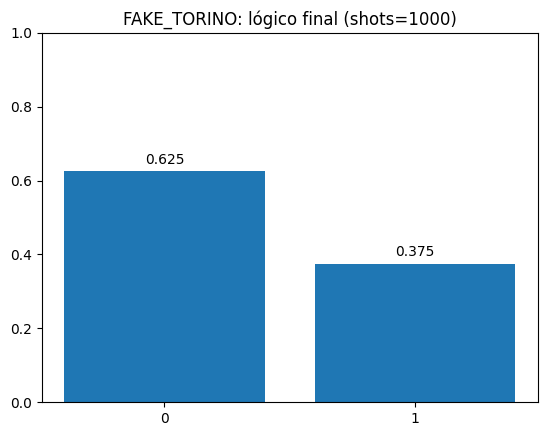

Tiempo total: 35.00s


In [1]:
# -*- coding: utf-8 -*-
# Requisitos:
#   pip install "qiskit>=2.1" "qiskit-aer>=0.14" "qiskit-ibm-runtime" matplotlib

import os, math, time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.primitives import BackendSamplerV2
from qiskit_ibm_runtime.fake_provider import FakeTorino  # backend simulado realista

# ========= Parámetros =========
USE_NOISE   = True
P1          = 3e-4
P2          = 3e-3
PM          = 1e-2
SHOTS       = 1_000
SEED_SIM    = 1234
THETA       = 2*np.arccos(np.sqrt(2/3))  # ~66/33 en medida final del lógico
# Inyección opcional de error físico (después del encoding, antes de síndromes)
ERROR_TYPE  = None         # None | 'X' | 'Z' | 'Y'
ERROR_POS   = None         # None | 0..8 (qubit físico data)
GRAFICAR    = "FAKE_TORINO"  # "SIN_RUIDO" | "CON_RUIDO" | "FAKE_TORINO"

# ========= Ruido (custom, solo si CON_RUIDO) =========
def build_noise_model(p1: float, p2: float, pm: float) -> NoiseModel:
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(depolarizing_error(p1, 1),
        ['x','y','z','h','s','sdg','t','tdg','rx','ry','rz','sx'])
    noise.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    ro = ReadoutError([[1-pm, pm],[pm,1-pm]])
    noise.add_all_qubit_readout_error(ro)
    return noise

# ========= Bloques de construcción Shor-9 =========
def encode_shor9(qc: QuantumCircuit, d):
    """
    Tripletes contiguos: (0,1,2), (3,4,5), (6,7,8)
    1) Repetición entre bloques: 0 -> 3,6
    2) H en centros de bloque: 0,3,6
    3) Repetición interna por bloque: (0->1,2), (3->4,5), (6->7,8)
    """
    qc.cx(d[0], d[3]); qc.cx(d[0], d[6])
    qc.h(d[0]); qc.h(d[3]); qc.h(d[6])
    qc.cx(d[0], d[1]); qc.cx(d[0], d[2])
    qc.cx(d[3], d[4]); qc.cx(d[3], d[5])
    qc.cx(d[6], d[7]); qc.cx(d[6], d[8])

def inject_error(qc: QuantumCircuit, d, error_type, pos):
    if error_type is None or pos is None:
        return
    if error_type.upper() == 'X':
        qc.x(d[pos])
    elif error_type.upper() == 'Z':
        qc.z(d[pos])
    elif error_type.upper() == 'Y':
        qc.y(d[pos])
    else:
        raise ValueError("ERROR_TYPE debe ser None|'X'|'Z'|'Y'")

def extract_syndromes_ztype(qc: QuantumCircuit, d, aZ):
    """
    Detecta errores X con estabilizadores Z: (Z0Z1, Z1Z2) por bloque.
    Usa 6 ancillas: aZ[0..1] para (0,1,2), aZ[2..3] para (3,4,5), aZ[4..5] para (6,7,8)
    """
    # (0,1,2)
    qc.cx(d[0], aZ[0]); qc.cx(d[1], aZ[0])   # Z0Z1
    qc.cx(d[1], aZ[1]); qc.cx(d[2], aZ[1])   # Z1Z2
    # (3,4,5)
    qc.cx(d[3], aZ[2]); qc.cx(d[4], aZ[2])   # Z3Z4
    qc.cx(d[4], aZ[3]); qc.cx(d[5], aZ[3])   # Z4Z5
    # (6,7,8)
    qc.cx(d[6], aZ[4]); qc.cx(d[7], aZ[4])   # Z6Z7
    qc.cx(d[7], aZ[5]); qc.cx(d[8], aZ[5])   # Z7Z8

def extract_syndromes_xtype(qc: QuantumCircuit, d, aX):
    """
    Detecta errores Z con estabilizadores X usando rotación de base en DATOS:
    S7 = X0 X1 X2 X3 X4 X5  (usa aX[0])
    S8 = X3 X4 X5 X6 X7 X8  (usa aX[1])
    Receta: H(datos subset) -> CX data->ancilla -> H(datos subset)
    """
    # S7
    for idx in [0,1,2,3,4,5]: qc.h(d[idx])
    for idx in [0,1,2,3,4,5]: qc.cx(d[idx], aX[0])
    for idx in [0,1,2,3,4,5]: qc.h(d[idx])
    # S8
    for idx in [3,4,5,6,7,8]: qc.h(d[idx])
    for idx in [3,4,5,6,7,8]: qc.cx(d[idx], aX[1])
    for idx in [3,4,5,6,7,8]: qc.h(d[idx])

def correct_bitflip(qc: QuantumCircuit, c_ancx, d):
    """
    Mapeo estándar por bloque con máscara sobre el creg c_ancx (6 bits).
    (0,1,2): 1,3,2   (3,4,5): 4,12,8   (6,7,8): 16,48,32
    """
    with qc.if_test((c_ancx, 1)):   qc.x(d[0])
    with qc.if_test((c_ancx, 3)):   qc.x(d[1])
    with qc.if_test((c_ancx, 2)):   qc.x(d[2])

    with qc.if_test((c_ancx, 4)):   qc.x(d[3])
    with qc.if_test((c_ancx, 12)):  qc.x(d[4])
    with qc.if_test((c_ancx, 8)):   qc.x(d[5])

    with qc.if_test((c_ancx, 16)):  qc.x(d[6])
    with qc.if_test((c_ancx, 48)):  qc.x(d[7])
    with qc.if_test((c_ancx, 32)):  qc.x(d[8])

def correct_phaseflip(qc: QuantumCircuit, c_ancz, d):
    """
    Con dos síndromes X-type:
    c_ancz = (S7, S8) => 01 -> bloque 0..2 ; 11 -> bloque 3..5 ; 10 -> bloque 6..8
    Aplicamos Z al primer qubit del bloque (0,3,6).
    """
    with qc.if_test((c_ancz, 1)):  qc.z(d[0])  # 01
    with qc.if_test((c_ancz, 3)):  qc.z(d[3])  # 11
    with qc.if_test((c_ancz, 2)):  qc.z(d[6])  # 10

def decode_shor9(qc: QuantumCircuit, d):
    # Deshacer repetición interna
    qc.cx(d[0], d[1]); qc.cx(d[0], d[2])
    qc.cx(d[3], d[4]); qc.cx(d[3], d[5])
    qc.cx(d[6], d[7]); qc.cx(d[6], d[8])
    # Volver de base X en centros
    qc.h(d[0]); qc.h(d[3]); qc.h(d[6])
    # Deshacer repetición entre bloques
    qc.cx(d[0], d[3]); qc.cx(d[0], d[6])

# ========= Construcción del circuito completo =========
def build_shor_circuit(theta=THETA, error_type=ERROR_TYPE, error_pos=ERROR_POS) -> QuantumCircuit:
    d     = QuantumRegister(9, 'data')
    aZ    = QuantumRegister(6, 'aZ')    # estabilizadores Z-type
    aX    = QuantumRegister(2, 'aX')    # estabilizadores X-type
    c_ancx= ClassicalRegister(6, 'c_ancx')
    c_ancz= ClassicalRegister(2, 'c_ancz')
    c_fin = ClassicalRegister(1, 'final')
    qc    = QuantumCircuit(d, aZ, aX, c_ancx, c_ancz, c_fin, name='shor9')

    # Preparación del lógico (qubit 0)
    qc.ry(theta, d[0]); qc.barrier()

    # Encoding
    encode_shor9(qc, d); qc.barrier(label="encode")

    # Error (opcional)
    inject_error(qc, d, error_type, error_pos); qc.barrier(label="error")

    # Síndromes Z-type (detectan X)
    extract_syndromes_ztype(qc, d, aZ)
    for i in range(6): qc.measure(aZ[i], c_ancx[i])
    qc.barrier(label="measure_Ztype")

    # Síndromes X-type (detectan Z)
    extract_syndromes_xtype(qc, d, aX)
    qc.measure(aX[0], c_ancz[0])
    qc.measure(aX[1], c_ancz[1])
    qc.barrier(label="measure_Xtype")

    # Correcciones dinámicas
    correct_bitflip(qc, c_ancx, d)
    correct_phaseflip(qc, c_ancz, d)
    qc.barrier(label="correct")

    # Decodificación y medida final
    decode_shor9(qc, d); qc.barrier(label="decode")
    qc.measure(d[0], c_fin[0])
    return qc

# ========= Sampler y utilidades =========
def run_sampler(circ: QuantumCircuit, backend, shots: int) -> Counter:
    sampler = BackendSamplerV2(backend=backend)
    res = sampler.run([circ], shots=shots).result()[0]
    return Counter(res.join_data().get_counts())

def marginalize_bit(circ: QuantumCircuit, counts: Counter, clbit) -> dict:
    # Robusto a claves con espacios entre registros
    idx = circ.clbits.index(clbit)
    tot = sum(counts.values())
    p1  = 0
    for k, c in counts.items():
        if not isinstance(k, str): 
            continue
        bits = ''.join(ch for ch in k if ch in '01')
        if len(bits) <= idx: 
            continue
        if bits[-1 - idx] == '1':
            p1 += c
    p1 /= (tot if tot else 1)
    return {'0': 1 - p1, '1': p1}

def plot_bar(probs: dict, title: str):
    plt.bar(probs.keys(), probs.values()); plt.ylim(0, 1)
    for x,v in probs.items(): plt.text(x, min(1.0, v+0.02), f"{v:.3f}", ha='center')
    plt.title(title); plt.show()

# ========= Main =========
def main(graficar: str):
    qc = build_shor_circuit(theta=THETA, error_type=ERROR_TYPE, error_pos=ERROR_POS)
    n_threads = max(1, math.floor(os.cpu_count() / 3))

    if graficar == "SIN_RUIDO":
        backend = AerSimulator(method="automatic", seed_simulator=SEED_SIM)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED_SIM)
        counts = run_sampler(qc_t, backend, SHOTS)

    elif graficar == "CON_RUIDO":
        noise = build_noise_model(P1, P2, PM)
        backend = AerSimulator(method="automatic", noise_model=noise, seed_simulator=SEED_SIM)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, basis_gates=noise.basis_gates,
                         optimization_level=3, seed_transpiler=SEED_SIM)
        counts = run_sampler(qc_t, backend, SHOTS)

    elif graficar == "FAKE_TORINO":
        fake = FakeTorino()
        backend = AerSimulator.from_backend(fake, seed_simulator=SEED_SIM)
        backend.set_options(max_parallel_threads=n_threads,
                            max_parallel_experiments=n_threads,
                            fusion_enable=True, blocking_enable=True)
        qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED_SIM)
        counts = run_sampler(qc_t, backend, SHOTS)

    else:
        raise ValueError("graficar debe ser 'SIN_RUIDO', 'CON_RUIDO' o 'FAKE_TORINO'.")

    # Resultados
    probs_final = marginalize_bit(qc_t, counts, qc_t.cregs[-1][0])  # 'final'[0]
    print(f"{graficar}: P(final) = {probs_final}")
    plot_bar(probs_final, f"{graficar}: lógico final (shots={SHOTS})")

if __name__ == "__main__":
    t0 = time.time()
    main(GRAFICAR)
    print(f"Tiempo total: {time.time() - t0:.2f}s")
